# Exploratory Data Analysis

## Setup

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conf = SparkConf()
conf.setAppName("ML Data Preparation")
conf.setMaster("local")
conf.set("spark.hadoop.fs.defaultFS", "file:///")
sc = SparkContext.getOrCreate(conf)
sc.setLogLevel("ERROR")
spark = SparkSession.builder.appName("App") \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/15 23:00:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Feature Selection

### Available Attributes

Our goal is to predict `ArrDelay` with the help of the other variables.

- The following table lists all attributes available in the dataset.
- Our goal is to predict `ArrDelay` with the help of other variables.
- Some of the attributes are not available at the time of takeoff (marked as ~~strikethrough~~) -> Removed from the dataset.

| #  | Name               | Description                                                            | Comment                  |
|----|--------------------|-------------------------------------------|--------------------------|
| 1  | `Year`               | 1987-2008                               | Check whether has impact |
| 2  | `Month`              | 1-12                                    | YES (Month+Day -> Disruptions on special days) |
| 3  | `DayofMonth`         | 1-31                                    | YES (Month+Day -> Disruptions on special days) |
| 4  | `DayOfWeek`          | 1 (Monday) - 7 (Sunday)                 | Check whether has impact |
| 5  | `DepTime`            | actual departure time (local, hhmm)     | MAYBE NOT                |
| 6  | `CRSDepTime`         | scheduled departure time (local, hhmm)  | MAYBE NOT                |
| ~~7~~  | ~~`ArrTime`~~    | ~~actual arrival time (local, hhmm)~~   |
| 8  | `CRSArrTime`         | scheduled arrival time (local, hhmm)    | MAYBE YES (Could have impact on overall busyness) |
| 9  | `UniqueCarrier`      | unique carrier code                     | YES (One-hot encoding)   |
| 10 | `FlightNum`          | flight number                           | NO (No new information + difficult to encode) |
| 11 | `TailNum`            | plane tail number                       | NO (Problematic airplanes shouldn't exist + difficult to encode) |
| ~~12~~ | ~~`ActualElapsedTime`~~  | ~~in minutes~~                  |
| 13 | `CRSElapsedTime`     | in minutes                              | YES (planned duration of flight) |
| ~~14~~ | ~~`AirTime`~~    | ~~in minutes~~                          |
| **15** | **`ArrDelay`**   | **arrival delay, in minutes**           |
| 16 | `DepDelay`           | departure delay, in minutes             | YES (departure delay directly implies arrival delay) |
| 17 | `Origin`             | origin IATA airport code                | MAYBE YES (determines route; how to encode?) |
| 18 | `Dest`               | destination IATA airport code           | MAYBE YES (determines route + some airports may be less organized; how to encode?) |
| 19 | `Distance`           | in miles                                | YES
| ~~20~~ | ~~`TaxiIn`~~     | ~~taxi in time, in minutes~~            |
| 21 | `TaxiOut`            | taxi out time in minutes                | NO (= time of plane on ground)
| 22 | `Cancelled`          | was the flight cancelled?               | FILTER cancelled flights before
| 23 | `CancellationCode`   | reason for cancellation                 | NO
| ~~24~~ | ~~`Diverted`~~           | ~~1 = yes, 0 = no~~             |
| ~~25~~ | ~~`CarrierDelay`~~       | ~~in minutes~~                  |
| ~~26~~ | ~~`WeatherDelay`~~       | ~~in minutes~~                  |
| ~~27~~ | ~~`NASDelay`~~           | ~~in minutes~~                  |
| ~~28~~ | ~~`SecurityDelay`~~      | ~~in minutes~~                  |
| ~~29~~ | ~~`LateAircraftDelay`~~  | ~~in minutes~~                  |

We are working with the subset of the data concerned with the year 2007.

In [2]:
dataframe = spark.read.load("./data/2007.csv.bz2", format="csv", sep=",", inferSchema="true", header="true")

# Drop the features for which the values are not available at the time of departure
dataframe = dataframe.drop(
    "ArrTime", 
    "ActualElapsedTime", 
    "AirTime", 
    "TaxiIn", 
    "Diverted", 
    "CarrierDelay", 
    "WeatherDelay", 
    "NASDelay", 
    "SecurityDelay", 
    "LateAircraftDelay"
)

In [3]:
# Drop the features which are not helpful for predicting ArrDelay
dataframe = dataframe.drop(
    "FlightNum",
    "TailNum",
    "TaxiOut",
    "CancellationCode"
)

In [4]:
print("Number of elements:", dataframe.count())

Number of elements: 7453215


In [5]:
dataframe.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)



- Flights which were cancelled (`Cancelled = 1`) do not have an arrival delay (`ArrDelay = "NA"`).
$\newline\Rightarrow$ Filter out these rows before applying the model.

- As now `Cancelled = 0` in all columns, we drop this column

In [6]:
dataframe.where((col("Cancelled") == 1) & (col("ArrDelay") != "NA")).count()

dataframe = dataframe.filter(col("Cancelled") == 0).drop("Cancelled")

Missing values are encoded as `"NA"`. Now we check, how many `"NA"` values there are per column.

In [7]:
# Show how many "NA" values exist per row
print('Number of "NA" values:')
dataframe.select([count(when(col(c) == "NA", c)).alias(c) for c in dataframe.columns]).show()

# (No "NaN" values)
#print('Number of "NaN" values:')
#dataframe.select([count(when(isnan(c), c)).alias(c) for c in dataframe.columns]).show()

# (No "Null" values)
#print('Number of "Null" values:')
#dataframe.select([count(when(isnull(c), c)).alias(c) for c in dataframe.columns]).show()

Number of "NA" values:


+----+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|
+----+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+
|   0|    0|         0|        0|      0|         0|         0|            0|           727|   17179|       0|     0|   0|       0|
+----+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+



We cannot use the instances where `ArrDelay` is `"NA"`, so we drop these rows. 

In [8]:
dataframe = dataframe.filter(col("ArrDelay") != "NA")
print("Number of elements:", dataframe.count())

Number of elements: 7275288


After filtering out the `"NA"` values for `ArrDelay`, we do not have any missing values anymore.

In [9]:
print('Number of "NA" values:')
dataframe.select([count(when(col(c) == "NA", c)).alias(c) for c in dataframe.columns]).show()

Number of "NA" values:


+----+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|
+----+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+
|   0|    0|         0|        0|      0|         0|         0|            0|             0|       0|       0|     0|   0|       0|
+----+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+



In [10]:
dataframe.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)



In [11]:
dataframe.write.parquet("data_1/2007", mode="overwrite")

## Histograms

In [12]:
dataframe = spark.read.parquet("data_1/2007")

In [13]:
def histogram(dataframe, col_name, num_buckets, range=None):
    value_counts = dataframe.groupBy(col(col_name)).count()
    value_counts_pd = value_counts.toPandas()
    # Convert the string variable to integers
    value_counts_pd[col_name] = value_counts_pd[col_name].astype(int)

    if range:
        value_counts_pd = value_counts_pd[
            (value_counts_pd[col_name] >= range[0]) & (value_counts_pd[col_name] <= range[1])
        ]

    # Extract data for plotting
    x = value_counts_pd[col_name]  # The distinct values (as integers)
    y = value_counts_pd['count']   # The counts

    # Create the histogram
    num_buckets = num_buckets
    plt.figure(figsize=(12, 6))
    plt.hist(x, bins=num_buckets, weights=y, edgecolor="black")

    # Add labels and title
    plt.title("Histogram")
    plt.xlabel(f"Values of {col_name}")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

- We only have a single value for `Year`, as we only loaded the data from `2007`.
- `Month`, `DayofMonth`, and `DayOfWeek` are distribute approximately uniformly.

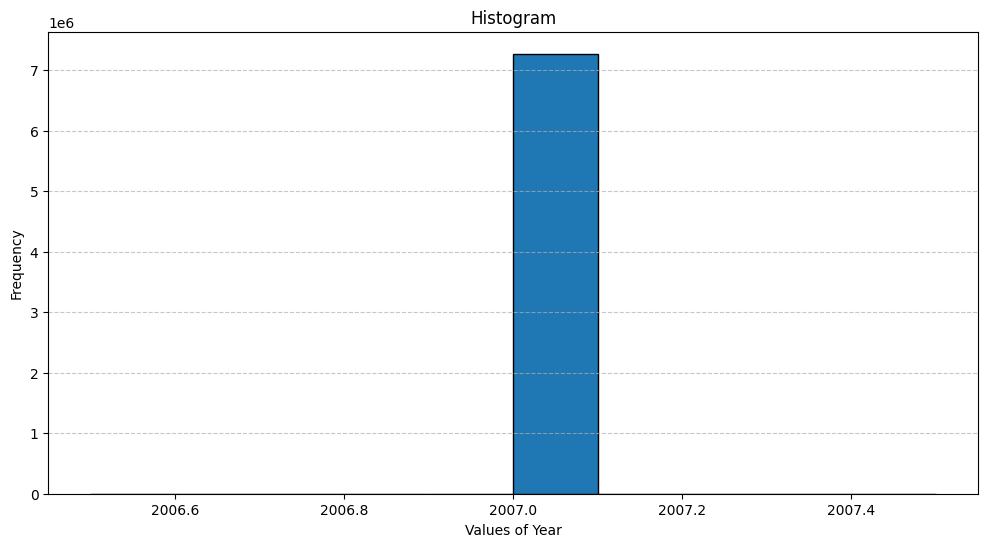

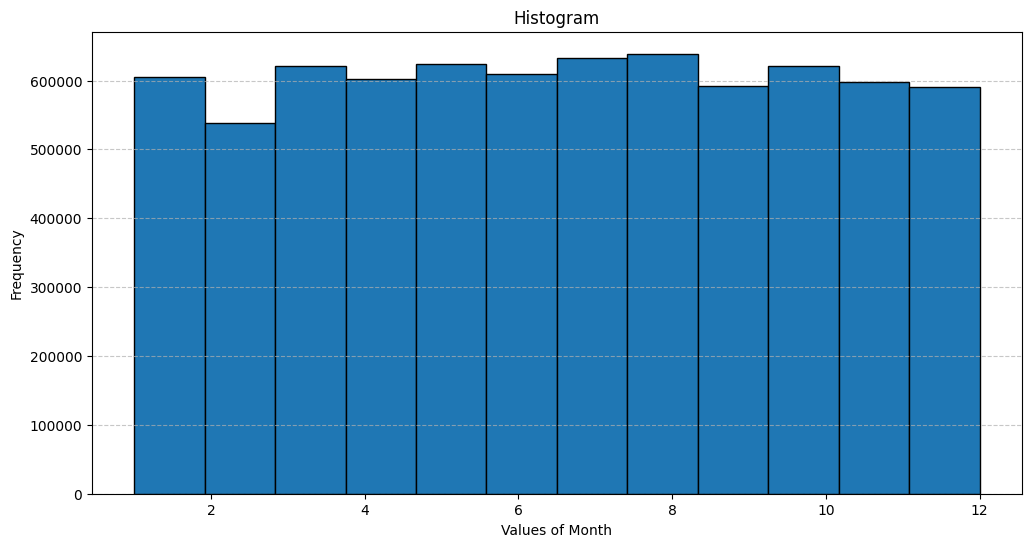

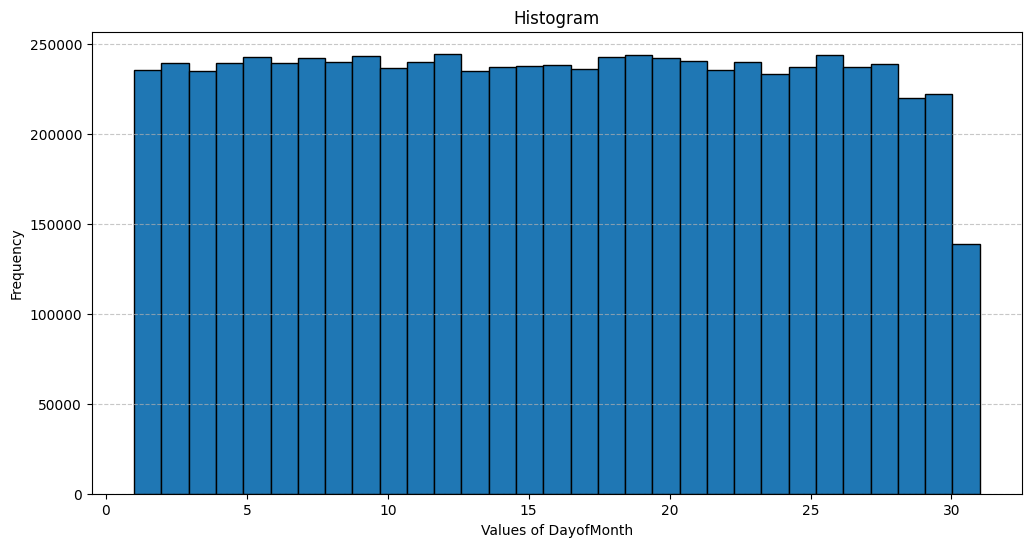

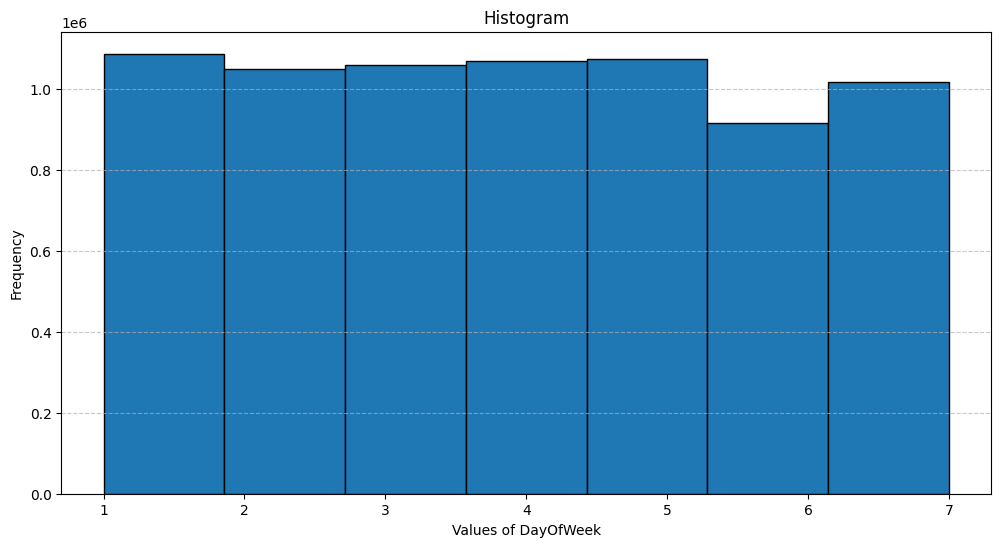

In [14]:
histogram(dataframe, "Year", 10)
histogram(dataframe, "Month", 12)
histogram(dataframe, "DayofMonth", 31)
histogram(dataframe, "DayOfWeek", 7)

- When looking at the distributions of the features `DepTime`, `CRSDepTime`, and `CRSArrTime`, we see that they are in the format `hhmm`, as values like `1060` do not exist
- We need to transform those attributes later, as we want to have a continuous domain (minutes after 00:00 instead of `hhmm`)

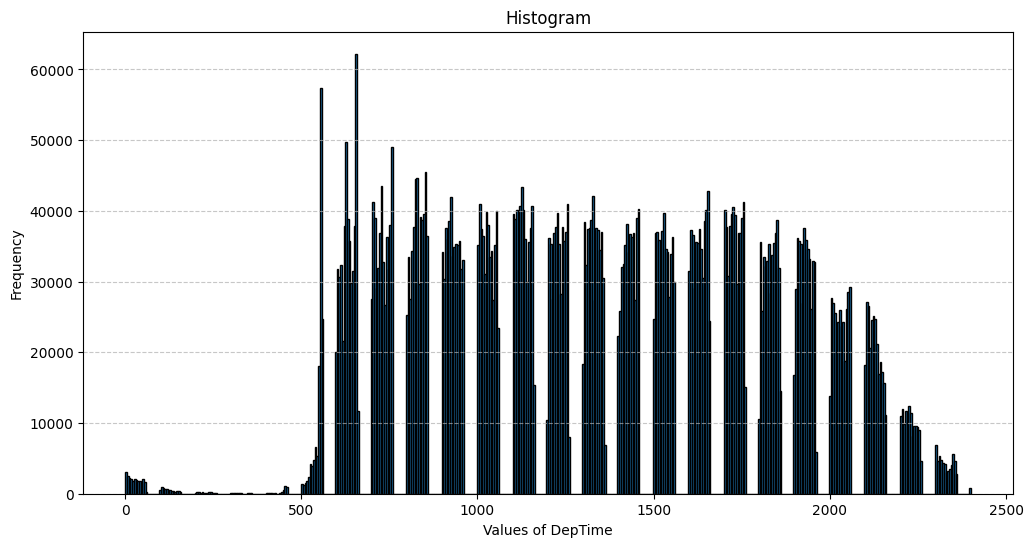

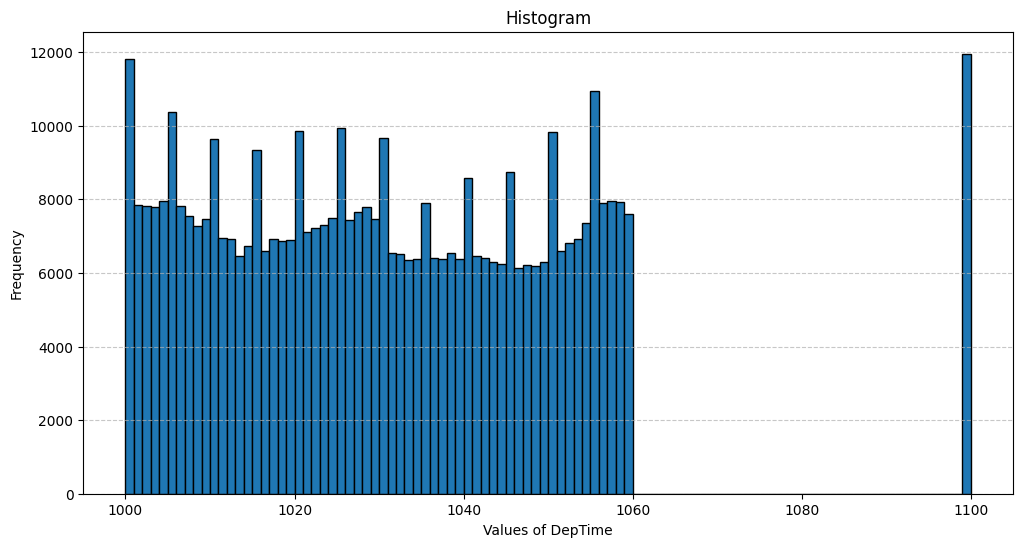

In [15]:
histogram(dataframe, "DepTime", 500)
histogram(dataframe, "DepTime", 100, [1000, 1100])

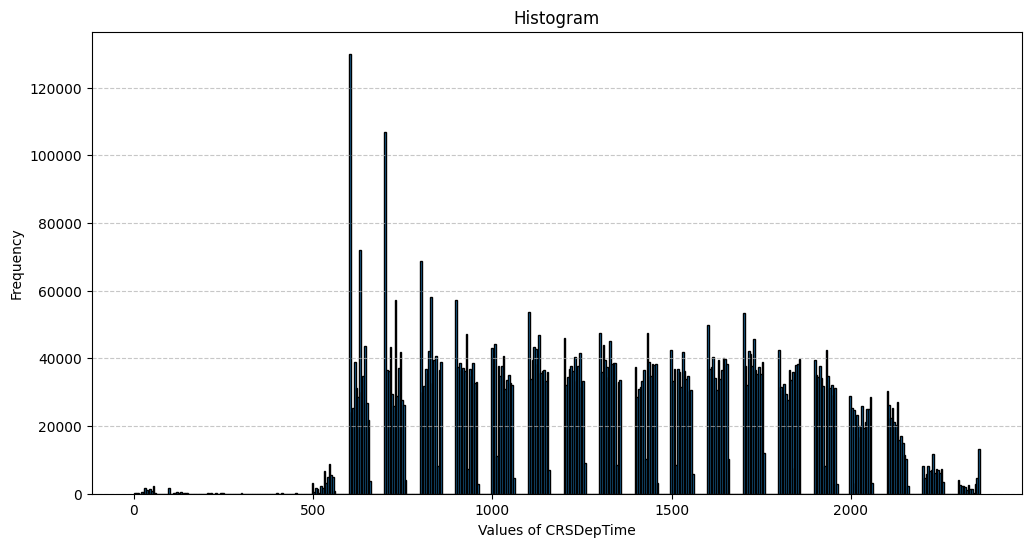

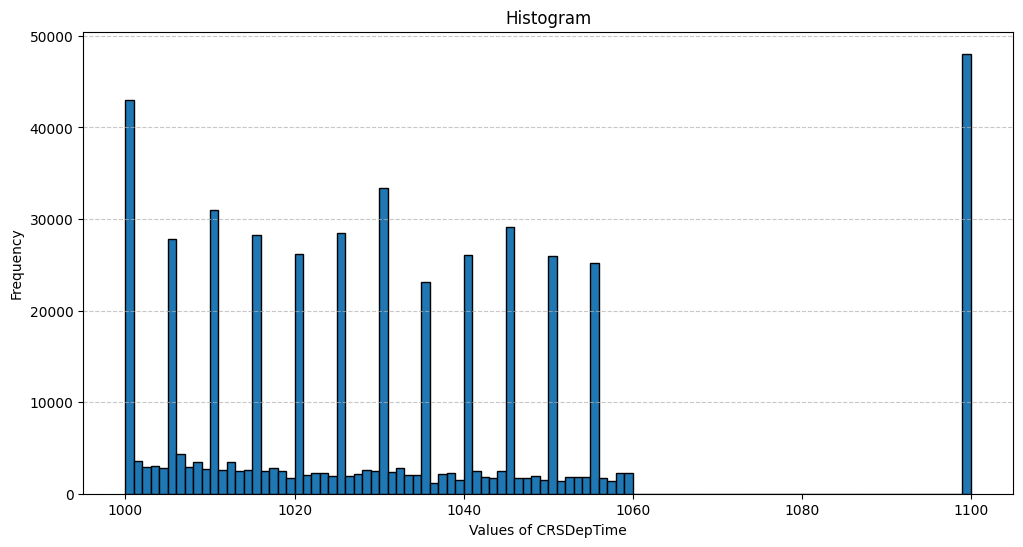

In [16]:
histogram(dataframe, "CRSDepTime", 500)
histogram(dataframe, "CRSDepTime", 100, [1000, 1100])

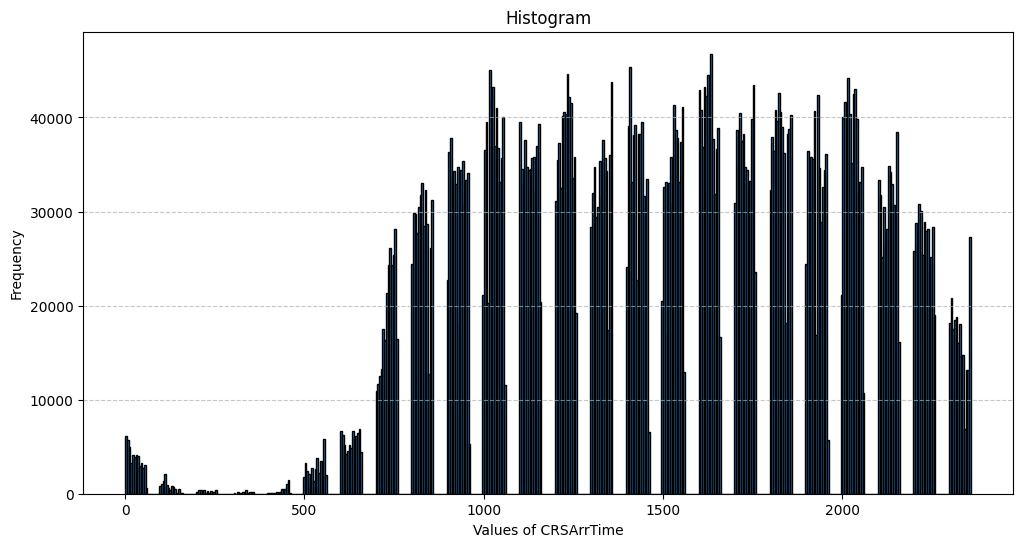

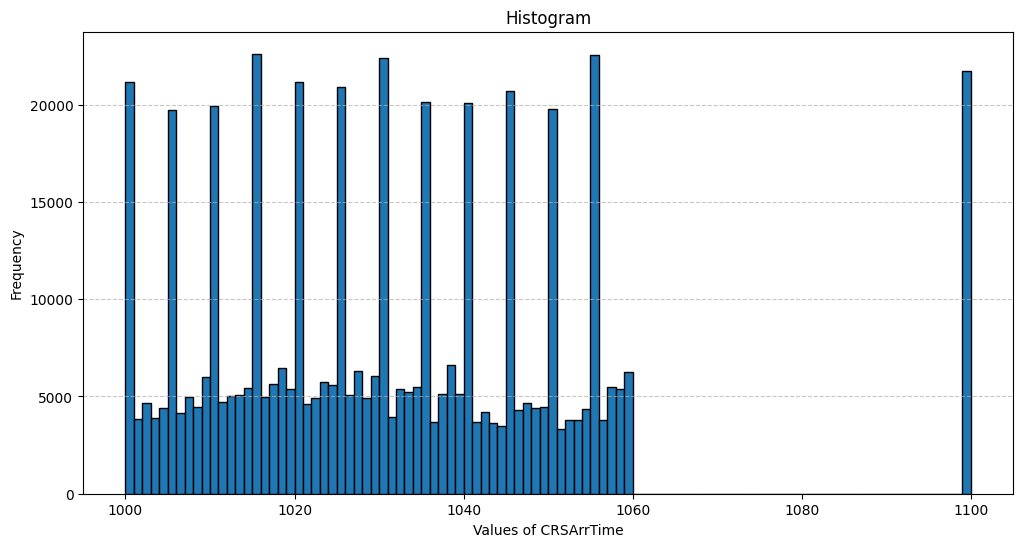

In [17]:
histogram(dataframe, "CRSArrTime", 500)
histogram(dataframe, "CRSArrTime", 100, [1000, 1100])

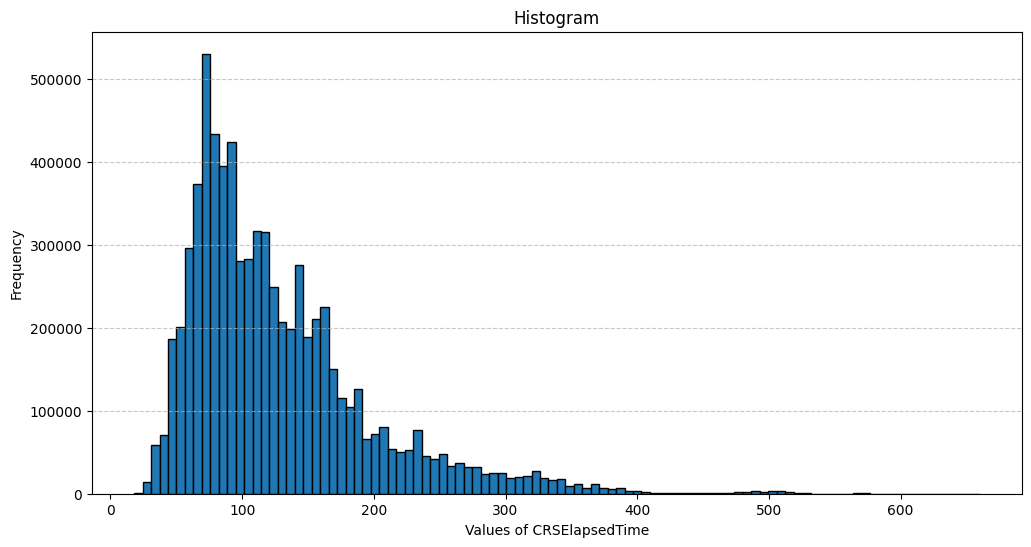

In [18]:
histogram(dataframe, "CRSElapsedTime", 100)

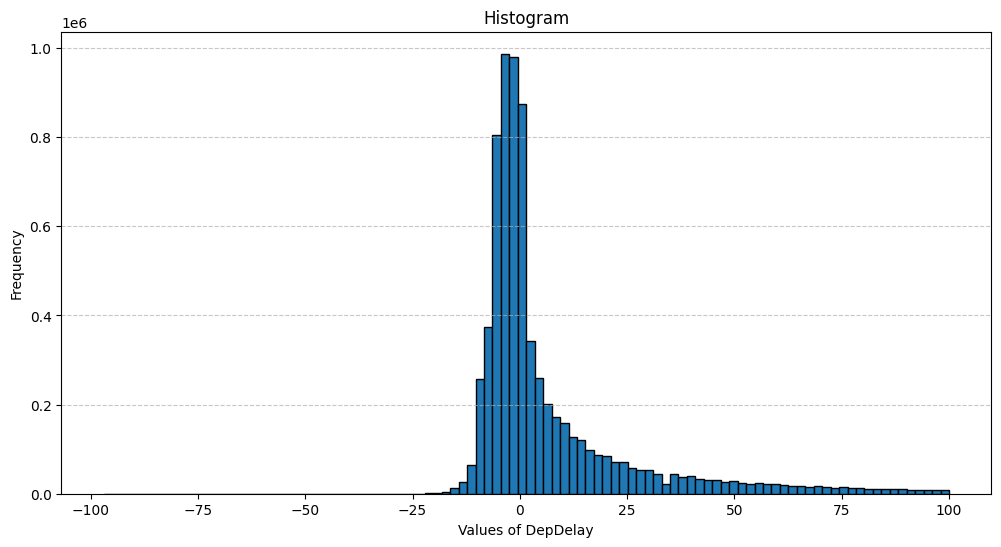

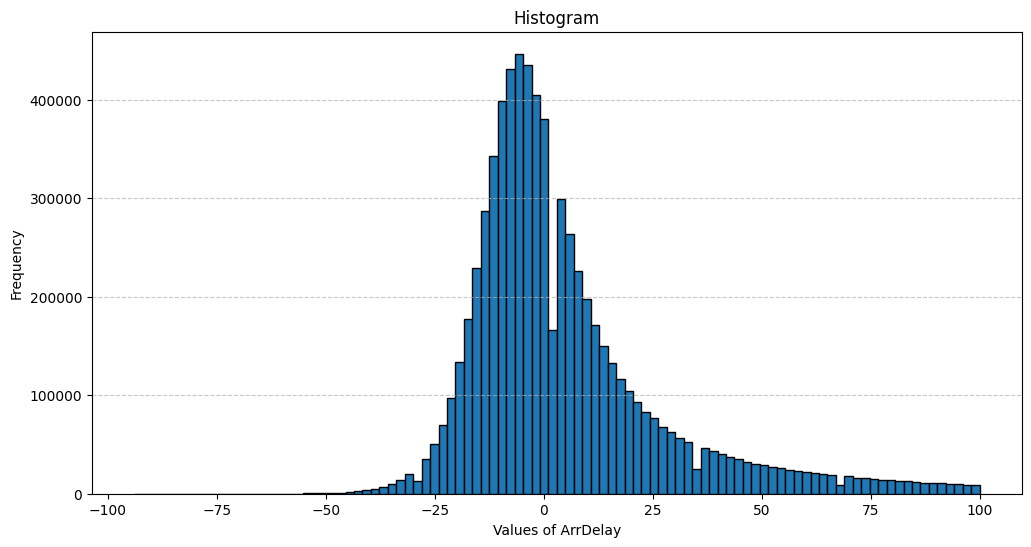

In [19]:
histogram(dataframe, "DepDelay", 100, [-100, 100])
histogram(dataframe, "ArrDelay", 100, [-100, 100])

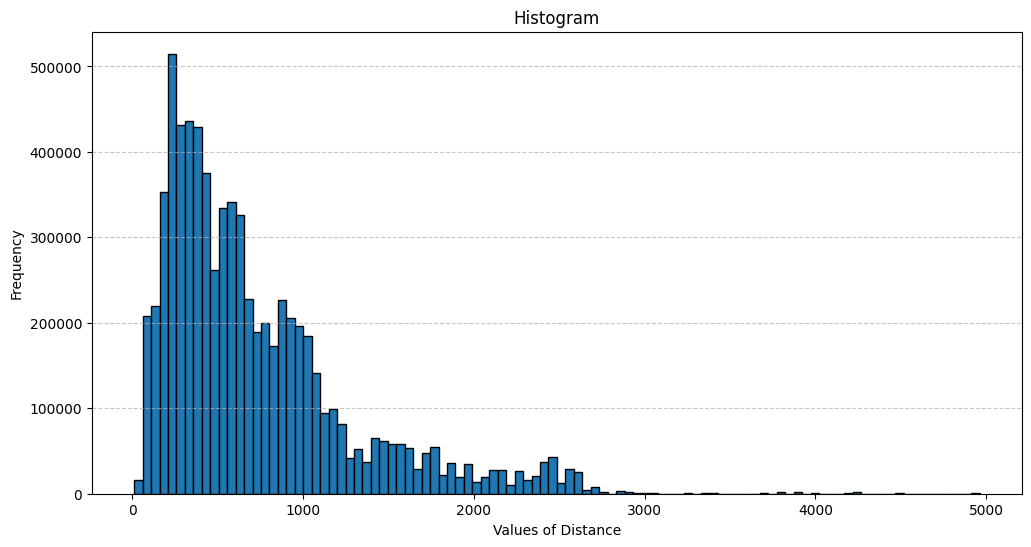

In [20]:
histogram(dataframe, "Distance", 100)

In [21]:
dataframe.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)



Change the datatypes of `CRSElapsedTime`, `ArrDelay`, and `DepDelay` to `Integer`.

In [22]:
# Change the datatypes to Integer
dataframe = dataframe.withColumn("CRSElapsedTime", dataframe.CRSElapsedTime.cast(IntegerType())) \
                     .withColumn("ArrDelay", dataframe.ArrDelay.cast(IntegerType())) \
                     .withColumn("DepDelay", dataframe.DepDelay.cast(IntegerType()))

In [23]:
def convertToMinutes(hhmm):
    hhmm = str(hhmm).strip().zfill(4)  # Ensure it is a string and remove leading/trailing spaces
    if not hhmm.isdigit():
        print(f"Encountered invalid time: {hhmm}")
        return None
    mins = int(hhmm[-2:])
    hours = int(hhmm[:-2])
    return hours * 60 + mins

convertToMinutesUDF = udf(convertToMinutes, IntegerType())

In [24]:
dataframe = dataframe.withColumn("DepTimeT", convertToMinutesUDF(col("DepTime"))) \
                     .withColumn("CRSDepTimeT", convertToMinutesUDF(col("CRSDepTime"))) \
                     .withColumn("CRSArrTimeT", convertToMinutesUDF(col("CRSArrTime")))

# Check whether transformation has worked as expected
dataframe.select("DepTime", "DepTimeT", "CRSDepTime", "CRSDepTimeT", "CRSArrTime", "CRSArrTimeT").show(10)

# Drop the original columns
dataframe = dataframe.drop("DepTime", "CRSDepTime", "CRSArrTime")

+-------+--------+----------+-----------+----------+-----------+
|DepTime|DepTimeT|CRSDepTime|CRSDepTimeT|CRSArrTime|CRSArrTimeT|
+-------+--------+----------+-----------+----------+-----------+
|   1232|     752|      1225|        745|      1340|        820|
|   1918|    1158|      1905|       1145|      2035|       1235|
|   2206|    1326|      2130|       1290|      2300|       1380|
|   1230|     750|      1200|        720|      1330|        810|
|    831|     511|       830|        510|      1000|        600|
|   1430|     870|      1420|        860|      1550|        950|
|   1936|    1176|      1840|       1120|      2130|       1290|
|    944|     584|       935|        575|      1225|        745|
|   1537|     937|      1450|        890|      1735|       1055|
|   1318|     798|      1315|        795|      1610|        970|
+-------+--------+----------+-----------+----------+-----------+
only showing top 10 rows



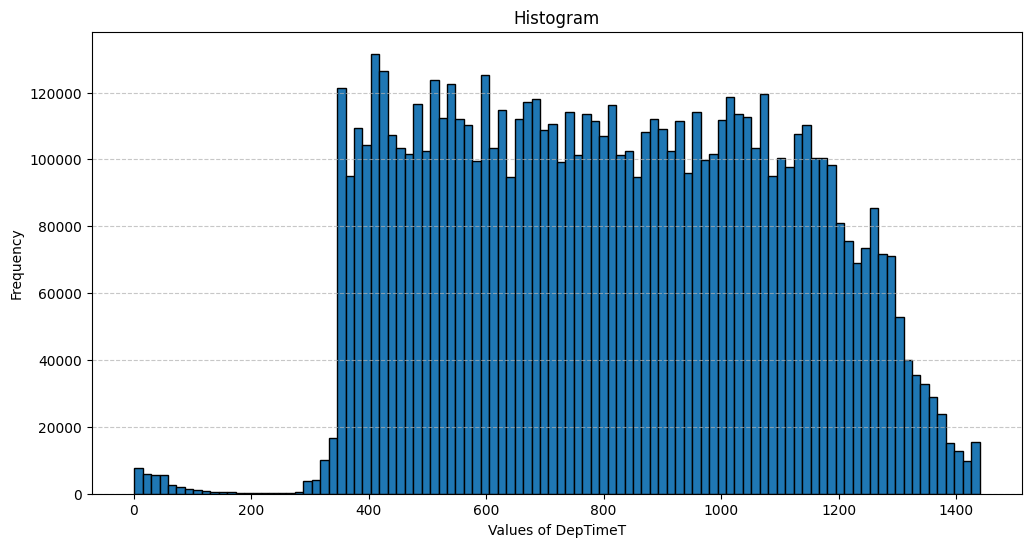

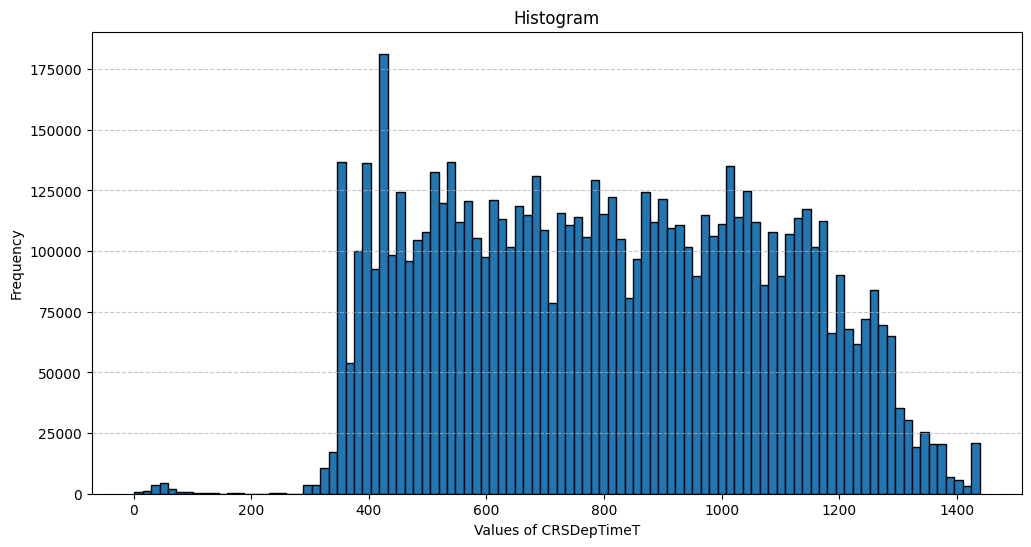

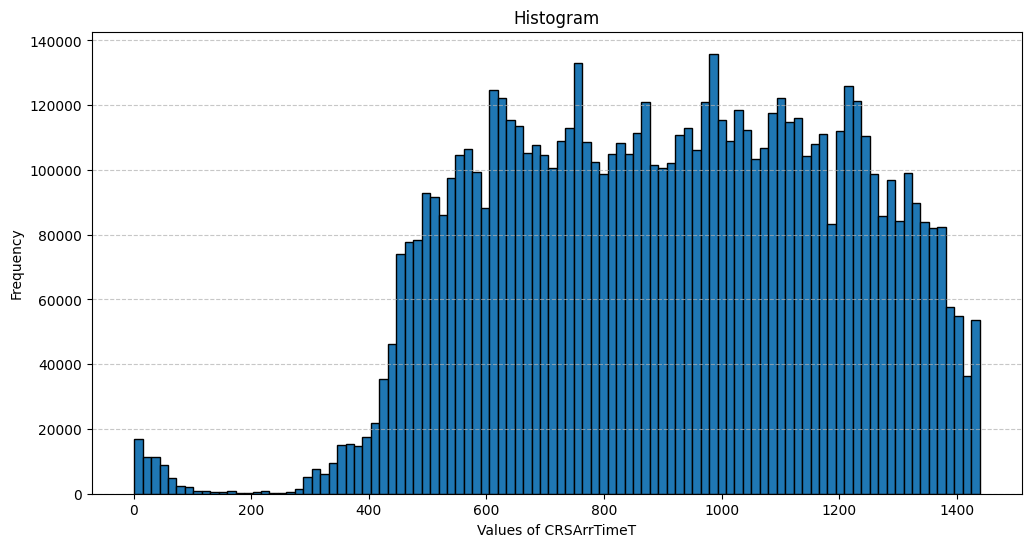

In [25]:
histogram(dataframe, "DepTimeT", 100)
histogram(dataframe, "CRSDepTimeT", 100)
histogram(dataframe, "CRSArrTimeT", 100)

In [26]:
dataframe.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- DepTimeT: integer (nullable = true)
 |-- CRSDepTimeT: integer (nullable = true)
 |-- CRSArrTimeT: integer (nullable = true)



In [27]:
dataframe.write.parquet("data_2/2007", mode="overwrite")

## Correlations

In [28]:
dataframe = spark.read.parquet("data_2/2007")

In [29]:
dataframe.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- DepTimeT: integer (nullable = true)
 |-- CRSDepTimeT: integer (nullable = true)
 |-- CRSArrTimeT: integer (nullable = true)



To check for *linear* relationships between the quantitative features, we compute the pairwise *Pearson correlations*.

In [30]:
numerical_cols = ["Month", "DayofMonth", "DayOfWeek", "DepTimeT", "CRSDepTimeT", "CRSArrTimeT", "CRSElapsedTime", "DepDelay", "ArrDelay", "Distance"]

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
vector_df = assembler.transform(dataframe).select("features")

correlation_matrix = Correlation.corr(vector_df, "features").head()[0]
correlation_array = correlation_matrix.toArray()
correlation_df = pd.DataFrame(correlation_array, index=numerical_cols, columns=numerical_cols)

Findings:
- `ArrDelay` correlates highly (`0.93`) with `DepDelay` making `DepDelay` a very important variable to predict `ArrDelay`
- `CRSElapsedTime` correlates highly (`0.97`) with `Distance`, making one of the variables redundant -> Drop feature `Distance`

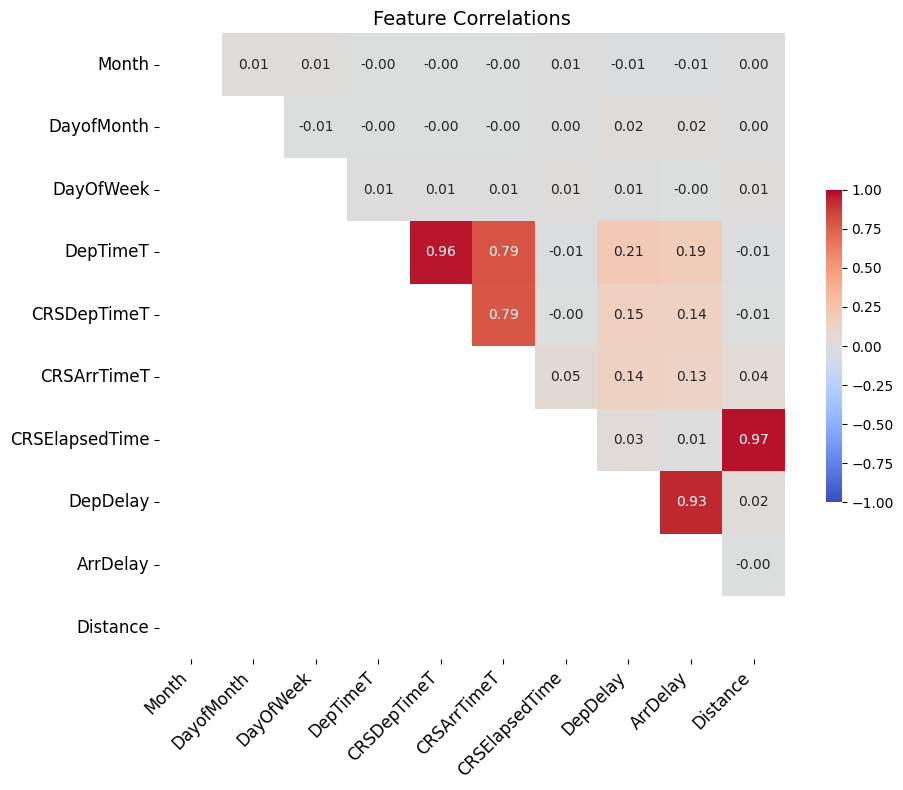

In [31]:
plt.figure(figsize=(10, 8))

mask = np.tril(np.ones_like(correlation_df, dtype=bool))

sns.heatmap(correlation_df,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1, vmax=1,
            square=True,
            cbar_kws={"shrink": .5})

plt.title("Feature Correlations", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [32]:
dataframe = dataframe.drop("Distance")

In [33]:
dataframe.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTimeT: integer (nullable = true)
 |-- CRSDepTimeT: integer (nullable = true)
 |-- CRSArrTimeT: integer (nullable = true)



## Handling Categorical Variables

In [34]:
def kde(dataframes, col_name, range=None, labels=None):
    """
    Plots KDE lines for a specified column across multiple DataFrames.

    Parameters:
        dataframes (list): List of Spark DataFrames to plot KDE for.
        col_name (str): The name of the column to plot KDE for.
        range (tuple or list): Optional range (min, max) for the KDE plot.
        labels (list): Optional list of labels for the datasets. Must match the number of DataFrames.
    """
    if labels is not None and len(labels) != len(dataframes):
        raise ValueError("The number of labels must match the number of DataFrames.")
    
    plt.figure(figsize=(12, 6))
    
    for i, dataframe in enumerate(dataframes):
        # Convert the Spark column to Pandas for easier plotting
        values = dataframe.select(col(col_name)).toPandas()[col_name].dropna()
        
        # Apply optional range filter
        if range:
            values = values[(values >= range[0]) & (values <= range[1])]
        
        # Ensure there are enough data points for KDE plotting
        if len(values) > 1:
            if labels is not None:
                sns.kdeplot(values, label=labels[i], linewidth=1)
            else:
                sns.kdeplot(values, linewidth=1)
        else:
            print(f"Not enough data to plot KDE for", labels[i] if labels is not None else "dataset")
    
    # Add labels, title, and legend
    plt.title(f"KDE Plot for {col_name}", fontsize=16)
    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if labels is not None:
        plt.legend(title="Datasets", fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

Does the carrier have an impact on the `ArrDelay`?
- We estimate the probability density of `ArrDelay` per `UniqueCarrier` by using KDE
- While all distributions have a long tail, two carriers (`"HA"` and `"AQ"`) are significantly better on time than the others
- We use this finding to create two new features (one-hot encoding): `PunctualCarrier` (`"HA"` and `"AQ"`) and `AverageCarrier (the rest)
    - This way, we can incorporate the carrier information without adding too many new features

20 distinct carriers: ['UA', 'AA', 'NW', 'EV', 'B6', 'DL', 'OO', 'F9', 'YV', 'US', 'AQ', 'MQ', 'OH', 'HA', 'XE', 'AS', 'FL', 'CO', 'WN', '9E']


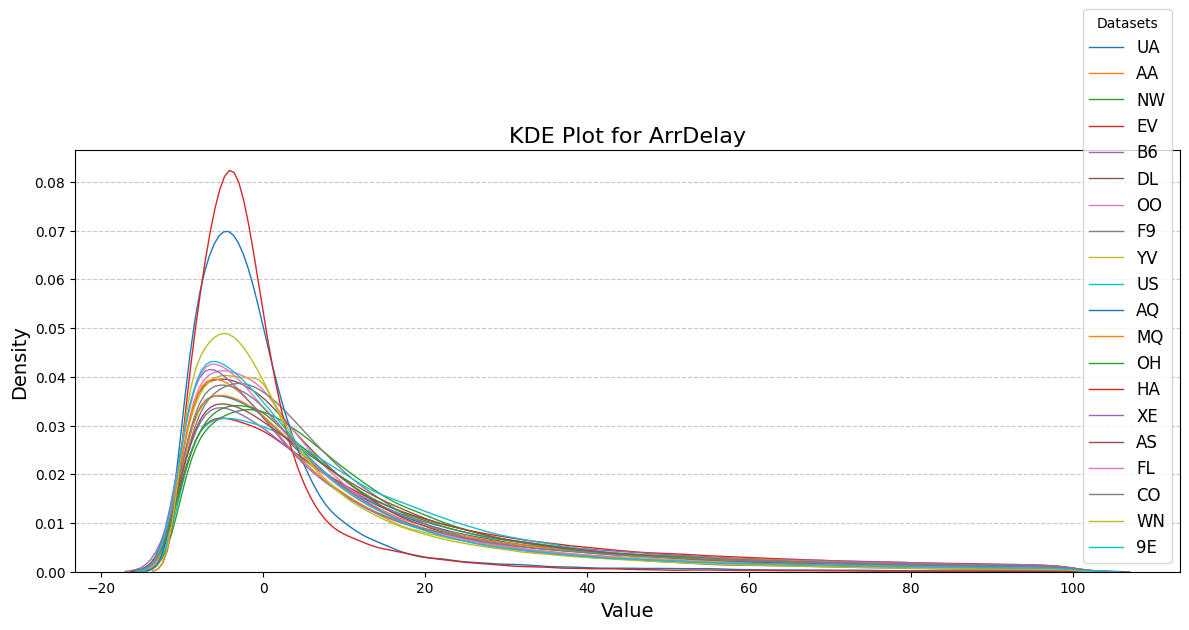

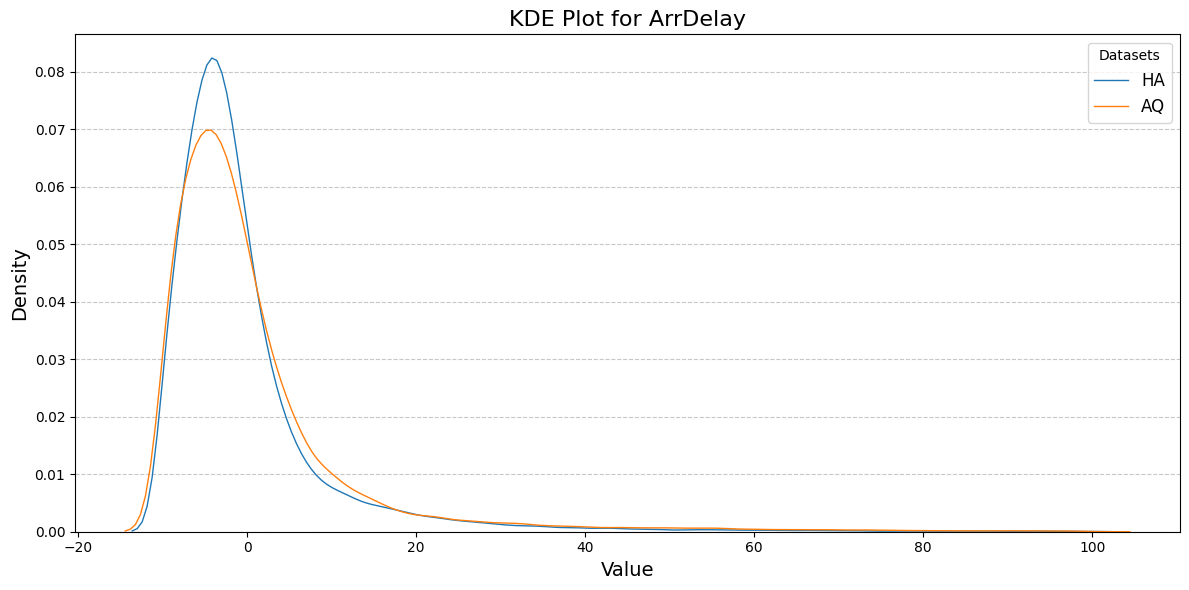

In [35]:
carriers = dataframe.select("UniqueCarrier").distinct().rdd.flatMap(lambda x: x).collect()
print(f"{len(carriers)} distinct carriers: {carriers}")
kde([dataframe.where(col("UniqueCarrier") == carrier) for carrier in carriers], "ArrDelay", [-10, 100], carriers)
kde([dataframe.where(col("UniqueCarrier") == carrier) for carrier in ["HA", "AQ"]], "ArrDelay", [-10, 100], ["HA", "AQ"])

In [36]:
punctual_carriers = ["HA", "AQ"]
print(punctual_carriers)

average_carriers = list(set(carriers) - set(punctual_carriers))
print(average_carriers)

['HA', 'AQ']
['US', 'B6', 'FL', 'XE', 'AS', 'CO', 'EV', 'AA', '9E', 'UA', 'WN', 'OH', 'DL', 'OO', 'F9', 'MQ', 'NW', 'YV']


In [37]:
print(dataframe.filter(col("UniqueCarrier").isin(punctual_carriers)).count(), "flights of punctual carriers.")
print(dataframe.filter(col("UniqueCarrier").isin(average_carriers)).count(), "flights of average carriers.")

101892 flights of punctual carriers.
7173396 flights of average carriers.


In [38]:
dataframe = dataframe.withColumn(
    "PunctualCarrier",
    when(col("UniqueCarrier").isin(punctual_carriers), 1).otherwise(0)
)

dataframe = dataframe.withColumn(
    "AverageCarrier",
    when(col("UniqueCarrier").isin(average_carriers), 1).otherwise(0)
)

# Check whether one-hot encoding was successful
dataframe.groupBy("PunctualCarrier").agg(count("PunctualCarrier")).show()
dataframe.groupBy("AverageCarrier").agg(count("AverageCarrier")).show()

dataframe = dataframe.drop("UniqueCarrier")

+---------------+----------------------+
|PunctualCarrier|count(PunctualCarrier)|
+---------------+----------------------+
|              1|                101892|
|              0|               7173396|
+---------------+----------------------+

+--------------+---------------------+
|AverageCarrier|count(AverageCarrier)|
+--------------+---------------------+
|             1|              7173396|
|             0|               101892|
+--------------+---------------------+



- `Month`, `DayofMonth`, and `DayOfWeek` *by themselves* do not have a discernible impact on `ArrDelay`
- Nevertheless, `Month` and `DayofMonth` together can identify a specific date and could thus have an impact when combined
- `DayOfWeek` is dropped to keep the feature space smaller

12 distinct months: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


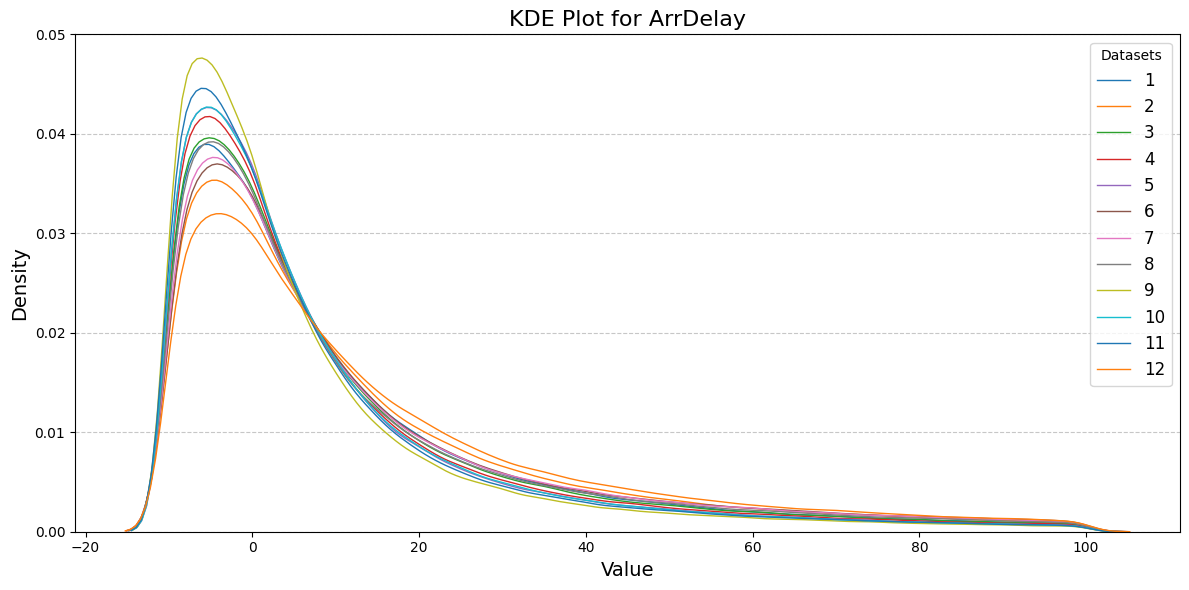

In [39]:
months = dataframe.select("Month").distinct().sort("Month").rdd.flatMap(lambda x: x).collect()
print(f"{len(months)} distinct months: {months}")
kde([dataframe.where(col("Month") == month) for month in months], "ArrDelay", [-10, 100], months)

31 distinct days of month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


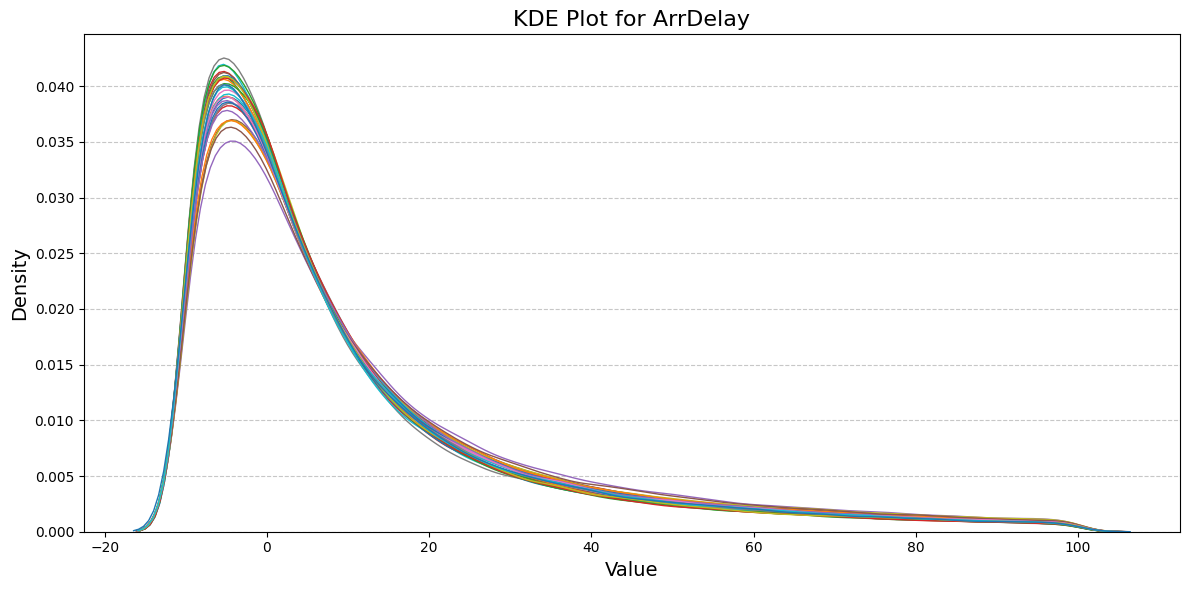

In [40]:
days_of_month = dataframe.select("DayofMonth").distinct().sort("DayofMonth").rdd.flatMap(lambda x: x).collect()
print(f"{len(days_of_month)} distinct days of month: {days_of_month}")
kde([dataframe.where(col("DayofMonth") == day_of_month) for day_of_month in days_of_month], "ArrDelay", [-10, 100])

7 distinct days of week: [1, 2, 3, 4, 5, 6, 7]


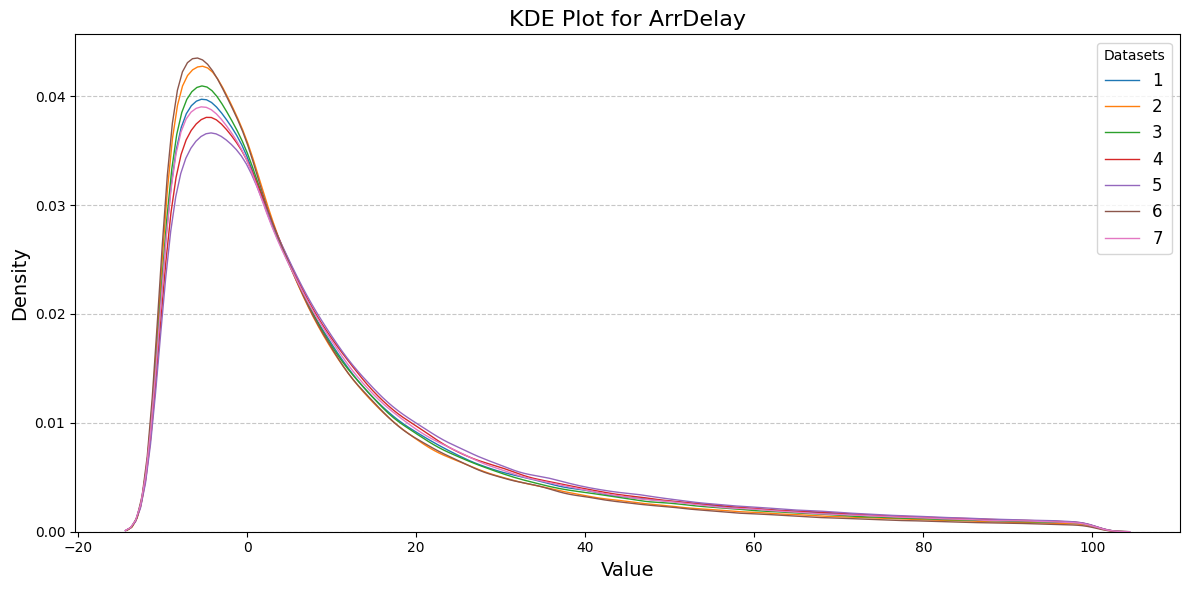

In [41]:
days = dataframe.select("DayOfWeek").distinct().sort("DayOfWeek").rdd.flatMap(lambda x: x).collect()
print(f"{len(days)} distinct days of week: {days}")
kde([dataframe.where(col("DayOfWeek") == day) for day in days], "ArrDelay", [-10, 100], days)

In [47]:
dataframe = dataframe.drop("DayOfWeek")

- `Origin` and `Dest` have an impact on `ArrDelay`, but clustering is necessary for further insight
- This is out of scope for this project, which is why the two columns are dropped

304 distinct origins: ['BGM', 'DLG', 'PSE', 'INL', 'MSY', 'GEG', 'SNA', 'BUR', 'GRB', 'GTF', 'IDA', 'GRR', 'LWB', 'EUG', 'PSG', 'PVD', 'GSO', 'MYR', 'ISO', 'OAK', 'MSN', 'COD', 'BTM', 'FAR', 'FSM', 'MQT', 'SCC', 'DCA', 'RFD', 'MLU', 'CID', 'LWS', 'GTR', 'WRG', 'MTH', 'HLN', 'LEX', 'RDM', 'FLO', 'ORF', 'SCE', 'EVV', 'KTN', 'CRW', 'CWA', 'SAV', 'TRI', 'CDV', 'CMH', 'MOD', 'CAK', 'TYR', 'ADK', 'CHO', 'MOB', 'PNS', 'MCN', 'CEC', 'LIH', 'IAH', 'HNL', 'SHV', 'ERI', 'GST', 'SJC', 'CVG', 'TOL', 'BUF', 'LGA', 'TLH', 'ACT', 'HPN', 'RDD', 'AUS', 'MLI', 'SJU', 'ATW', 'DHN', 'AVL', 'GJT', 'LGB', 'LYH', 'BFL', 'GFK', 'RNO', 'SRQ', 'SBN', 'EYW', 'BJI', 'TTN', 'JAC', 'RST', 'CHS', 'TUL', 'HRL', 'RSW', 'IPL', 'AMA', 'ISP', 'MKC', 'BOS', 'MAF', 'MLB', 'TUP', 'EWR', 'LAS', 'BIS', 'JAN', 'ITO', 'FAI', 'XNA', 'HHH', 'DLH', 'DEN', 'RHI', 'EWN', 'SGU', 'ALB', 'CPR', 'LNK', 'OME', 'BOI', 'IAD', 'PSP', 'SBA', 'IYK', 'MEI', 'BRO', 'DRO', 'BMI', 'SEA', 'LAN', 'CMI', 'LRD', 'VLD', 'MCI', 'PIR', 'FLG', 'GRK', 'BNA

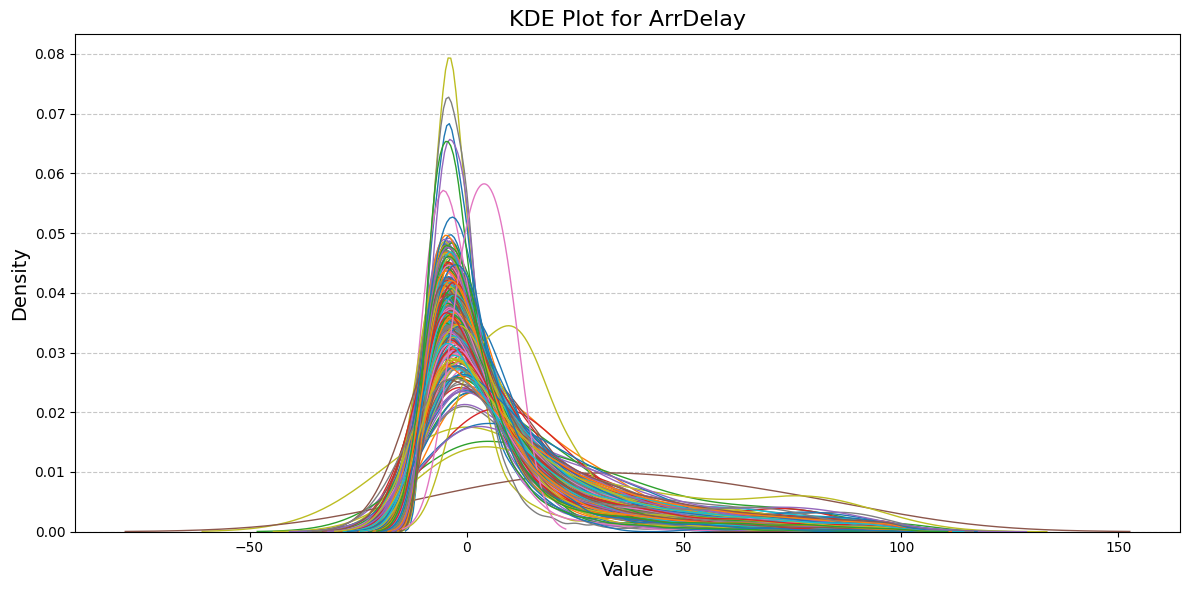

In [42]:
origins = dataframe.select("Origin").distinct().rdd.flatMap(lambda x: x).collect()
print(f"{len(origins)} distinct origins: {origins}")
kde([dataframe.where(col("Origin") == origin) for origin in origins], "ArrDelay", [-10, 100])

304 distinct destinations: ['BGM', 'PSE', 'DLG', 'INL', 'MSY', 'GEG', 'SNA', 'BUR', 'GRB', 'GTF', 'IDA', 'GRR', 'LWB', 'EUG', 'PSG', 'PVD', 'GSO', 'MYR', 'ISO', 'OAK', 'MSN', 'COD', 'FAR', 'BTM', 'FSM', 'MQT', 'SCC', 'DCA', 'RFD', 'MLU', 'CID', 'LWS', 'GTR', 'WRG', 'MTH', 'HLN', 'LEX', 'RDM', 'FLO', 'ORF', 'SCE', 'EVV', 'KTN', 'CRW', 'CWA', 'SAV', 'TRI', 'CDV', 'CMH', 'MOD', 'CAK', 'TYR', 'ADK', 'CHO', 'MOB', 'PNS', 'MCN', 'CEC', 'LIH', 'IAH', 'HNL', 'SHV', 'ERI', 'GST', 'SJC', 'CVG', 'TOL', 'BUF', 'LGA', 'TLH', 'ACT', 'HPN', 'RDD', 'AUS', 'MLI', 'SJU', 'ATW', 'DHN', 'AVL', 'GJT', 'LGB', 'LYH', 'BFL', 'GFK', 'RNO', 'SRQ', 'SBN', 'EYW', 'BJI', 'TTN', 'JAC', 'RST', 'CHS', 'TUL', 'HRL', 'RSW', 'IPL', 'ISP', 'AMA', 'MKC', 'BOS', 'MAF', 'MLB', 'TUP', 'EWR', 'LAS', 'BIS', 'JAN', 'ITO', 'FAI', 'XNA', 'HHH', 'DLH', 'DEN', 'RHI', 'EWN', 'SGU', 'ALB', 'CPR', 'LNK', 'OME', 'IAD', 'BOI', 'PSP', 'SBA', 'IYK', 'MEI', 'BRO', 'DRO', 'BMI', 'SEA', 'LAN', 'CMI', 'LRD', 'VLD', 'MCI', 'PIR', 'FLG', 'GRK',

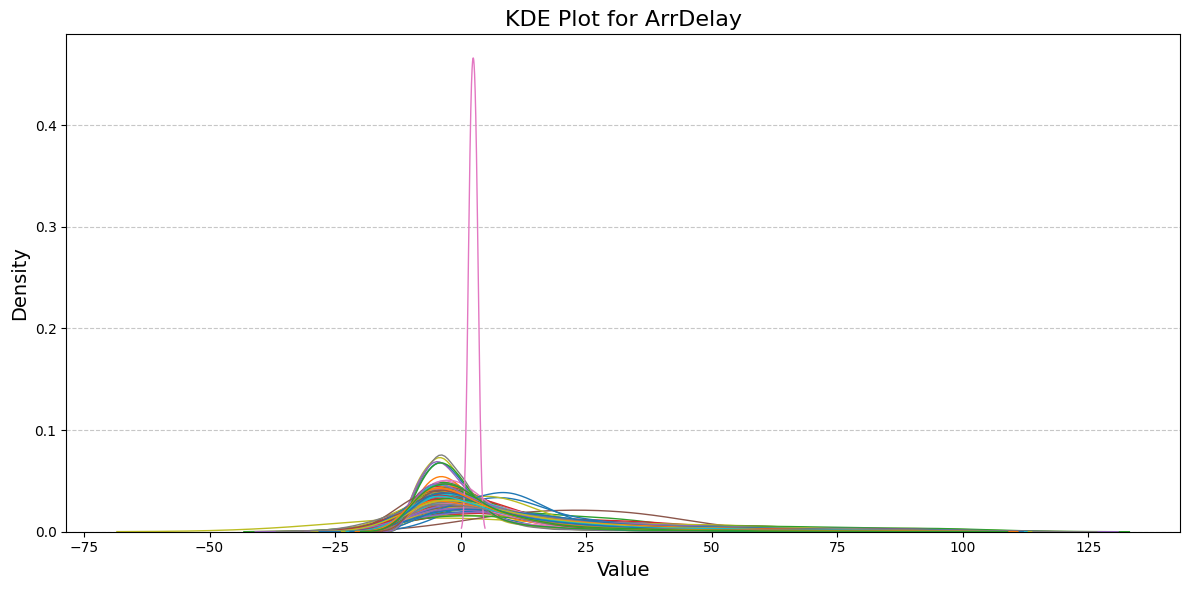

In [43]:
destinations = dataframe.select("Dest").distinct().rdd.flatMap(lambda x: x).collect()
print(f"{len(destinations)} distinct destinations: {destinations}")
kde([dataframe.where(col("Dest") == destination) for destination in destinations], "ArrDelay", [-10, 100])

In [44]:
dataframe = dataframe.drop("Origin", "Dest")

In [48]:
dataframe.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- DepTimeT: integer (nullable = true)
 |-- CRSDepTimeT: integer (nullable = true)
 |-- CRSArrTimeT: integer (nullable = true)
 |-- PunctualCarrier: integer (nullable = false)
 |-- AverageCarrier: integer (nullable = false)



In [49]:
dataframe.write.parquet("data/preprocessed/2007", mode="overwrite")